In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data

In [3]:
# Load CFashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1.0/255.0,))])
trainset = torchvision.datasets.FashionMNIST(root='data',
                                            train=True,
                                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=1024,
                                          num_workers=10, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='data',
                                            train=False,
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1024,
                                         num_workers=10, shuffle=True)

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.0%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



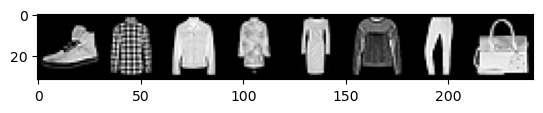

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img / 255.0
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))
    break

### Model

In [10]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10)
)
model = model.to(device)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)


In [15]:
# Generating a rando tensor
input_tensor = torch.rand(5, 28, 28).to(device)

# Feeding the tensor into the model
output = model(input_tensor)
print(output.shape)

torch.Size([5, 10])


### Loss, Optimizer and Evaluation Function

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [21]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    
    return test_loss, accuracy

In [22]:
test_lost, test_accuracy = evaluate(model, testloader, criterion)
print(f'test_loss: {test_lost}')
print(f'test_accuracy: {test_accuracy}')

test_loss: 76.5710205078125
test_accuracy: 10.62


### Train

In [23]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 100

In [24]:
# train
for epoch in range(max_epoch):
    running_loss = 0.0
    running_correct = 0.0   # to track number of correct predictions
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f'Epoch [{epoch+1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/100], Loss: 4070.8030, Accuracy: 56.82%, Test Loss: 1665.0656, Test Accuracy: 67.80%
Epoch [2/100], Loss: 1860.7559, Accuracy: 70.70%, Test Loss: 914.0149, Test Accuracy: 74.09%
Epoch [3/100], Loss: 1519.9169, Accuracy: 72.71%, Test Loss: 930.3560, Test Accuracy: 74.37%
Epoch [4/100], Loss: 1317.2844, Accuracy: 73.84%, Test Loss: 1547.0720, Test Accuracy: 75.66%
Epoch [5/100], Loss: 1087.8776, Accuracy: 75.67%, Test Loss: 1121.2547, Test Accuracy: 77.40%
Epoch [6/100], Loss: 1215.9635, Accuracy: 74.72%, Test Loss: 1167.7541, Test Accuracy: 75.46%
Epoch [7/100], Loss: 1124.6022, Accuracy: 75.30%, Test Loss: 2232.3183, Test Accuracy: 65.30%
Epoch [8/100], Loss: 1245.6851, Accuracy: 76.09%, Test Loss: 510.0618, Test Accuracy: 82.13%
Epoch [9/100], Loss: 1049.0081, Accuracy: 76.73%, Test Loss: 809.6675, Test Accuracy: 79.21%
Epoch [10/100], Loss: 1133.6282, Accuracy: 76.50%, Test Loss: 1234.0165, Test Accuracy: 76.92%
Epoch [11/100], Loss: 954.7865, Accuracy: 77.90%, Test Loss: 52

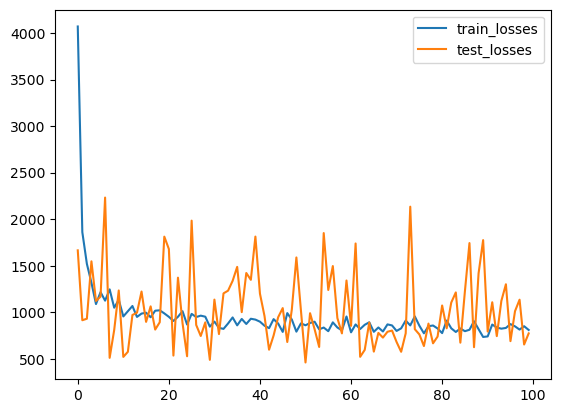

In [25]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

In [29]:
%matplotlib qt

plt.plot(train_accuracies, label='train_accuracies')
plt.plot(test_accuracies, label='test_accuracies')
plt.legend()